# DQN Implementation

### Environment Example
#### Switch2-v0
![Switch-2](https://raw.githubusercontent.com/koulanurag/ma-gym/master/static/gif/Switch2-v0.gif)
#### Switch4-v0
![Switch-4](https://raw.githubusercontent.com/koulanurag/ma-gym/master/static/gif/Switch4-v0.gif)

`Switch-n` is a grid world environment having `n agents` where each agent wants to move their corresponding home location (marked in boxes outlined in same colors).
Each agent receives only it's local position coordinates. The challenging part of the game is to pass through the narrow corridor through which only one agent can pass at a time. They need to coordinate to not block the pathway for the other. A reward of +5 is given to each agent for reaching their home cell. The episode ends when both agents has reached their home state or for a maximum of 100 steps in environment.

Action Space: `0: Down, 1: Left, 2: Up , 3: Right, 4: Noop`

Agent Observation : `Agent Coordinate + Steps in env.`

Best Score: `NA`

### Download Requirements and Set the Environment
The following command will download the required scripts and set up the environment. 

In [ ]:
!rm -rf /content/ma-gym  
!git clone https://github.com/koulanurag/ma-gym.git 
%cd /content/ma-gym 
!pip install -q -e . 
!apt-get install -y xvfb python-opengl x11-utils > /dev/null 2>&1
!pip install pyvirtualdisplay > /dev/null 2>&1
!apt-get install x11-utils
!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1
!pip install -U gym[atari] > /dev/null 2>&1

In [ ]:
%matplotlib inline
import gym
import ma_gym
from ma_gym.wrappers import Monitor
import matplotlib.pyplot as plt
import glob
import io
import base64
from IPython.display import HTML
from IPython import display as ipythondisplay

from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

"""
Utility functions to enable video recording of gym environment and displaying it
To enable video, just do "env = wrap_env(env)""
"""

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")
    

def wrap_env(env):
  env = Monitor(env, './video', force=True)
  return env

#### Example of playing Switch2-v0 Using Random Policy

In [ ]:
env = wrap_env(gym.make("Switch2-v0")) # Use "Switch4-v0" for the Switch-4 game
done_n = [False for _ in range(env.n_agents)]
ep_reward = 0

obs_n = env.reset()
while not all(done_n):
    obs_n, reward_n, done_n, info = env.step(env.action_space.sample())
    ep_reward += sum(reward_n)
    env.render()
env.close()
# To improve the training efficiency, render() is not necessary during the training.
# We provide the render and video code here just want to demonstrate how to debugging and analysis.
show_video()

Credit: Code above (Installation and random example) were written by Teaching Assistants from UCL's Multi Agent Artifical Intelligence course. All code below was written by me (Raymond Danks).


**Requirements**
* TensorFlow 2.0+ or PyTorch 1.4+ are recommended.
*   Algorithm is Multi-Agent, i.e., policy input is the observation/ state for each corresponding agent, not for all agents.

Training, Plotting, Testing and Explanation Included.



# Imports

In [ ]:
from numpy.random import seed
seed(3517174048)
import numpy as np
st0 = np.random.get_state()
#print("current seed?",st0[0][1])
import random
random.seed(111)

#The below is to stick the TensorFlow version, as concurrent updates can mess it up
%tensorflow_version 1.x
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Activation, Flatten
from keras.callbacks import TensorBoard
from keras.optimizers import Adam
from keras import optimizers
from collections import deque
from keras.layers import Activation, Dense
from collections import deque
from copy import deepcopy

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt


#### Code for Playing Switch2-v0


In [ ]:
class DQN_Switch_v2:
  
  def __init__(self):
    self.env = wrap_env(gym.make("Switch2-v0"))
    self.discount_rate = 0.9
    self.batch_size = 32
    self.training_episodes = 10000
    self.max_timesteps = 50 #Already defined by gym
    self.update_frequency = 32 #how often the networks are fitted
    self.epsilon_max = 1 #what epsilon starts at (before annealing)
    self.epsilon_projection = -0.2 #for linear interpolation
    self.epsilon_min = 0.3 #makes sure epsilon does not go below this value
    self.max_buffer_size = 100000
    self.exploration_episodes = 0 #no training in exploration
    self.testing_episodes = 1000 
    self.test_epsilon = 0 #some papers claim that a ~5% randomness during testing is beneficial

  def _Create_Model(self): # _ = private method.
    model = Sequential()
    model.add(Dense(50, input_dim=3, activation="relu")) # coordinates AND timestep (early and late game strats are different)
    model.add(Dense(5, activation="linear")) #Outputs = amount of actions
    model.compile(loss='mse',optimizer="Adam") 
    return model



  def _Update_Q_Policy(self,model,replay_batch):
    #This function is to update the Q learning ANN model and hence update the Q policy

    #The first step is to randomly sample some parts of the data batch:
    #Our buffer has a large amount of moves, 
    #however our asynchronous databatch will just be a randomly chosen batch of these:
    independent_batch = []
    for i in range(self.batch_size): 
      random_batch_index = random.randint(0, len(replay_batch)-1) #select random row of the batch
      random_batch = replay_batch[random_batch_index]
      if i == 0:
        independent_batch_messy = random_batch
      else:
        independent_batch_messy = np.vstack((independent_batch_messy,random_batch))
    #Now we have a random batch of the appropriate size.

    #columns of the batch go: state,action,new_state,reward,done, timestep

    #reformat matrix batch first
    independent_batch = np.zeros((self.batch_size,8))
    for i in range(len(independent_batch_messy)):
      first_coord_x = independent_batch_messy[i,0][0]
      first_coord_y = independent_batch_messy[i,0][1]
      action_int = independent_batch_messy[i,1]
      second_coord_x = independent_batch_messy[i,2][0][0]
      second_coord_y = independent_batch_messy[i,2][0][1]
      reward_int = independent_batch_messy[i,2][1]
      done_int = independent_batch_messy[i,2][2]
      timestep_int = independent_batch_messy[i,2][3]

      independent_batch[i,0] = first_coord_x 
      independent_batch[i,1] = first_coord_y
      independent_batch[i,2] = action_int
      independent_batch[i,3] = second_coord_x
      independent_batch[i,4] = second_coord_y
      independent_batch[i,5] = reward_int
      independent_batch[i,6] = done_int
      independent_batch[i,7] = timestep_int
    #Batch is now fully formatted

    #Firstly, we must gather  all of the current states:

    #convert to batch size x 2 matrix for Keras
    states = np.zeros((self.batch_size,3)) 
    for i in range(self.batch_size):
      states[i,0] = independent_batch[i][0]
      states[i,1] = independent_batch[i][1]
      states[i,2] = independent_batch[i][7]
    predicted_current_Q = model.predict(states) # this will output the Q values for all possible actions
    
    #now get the future states:
    future_states = np.zeros((self.batch_size,3))
    for i in range(self.batch_size):
      future_states[i,0] = independent_batch[i,3]
      future_states[i,1] = independent_batch[i,4]
      future_states[i,2] = independent_batch[i,7]

    predicted_future_Q = model.predict(future_states)

    #Now we must define "target"; this is done slightly in our previous Q Learning system:
    targets = []
    for j in range(self.batch_size):
      done = independent_batch[j,6]
      reward = independent_batch[j,5]
      if done:
        target = reward
      else:
        V = np.max(predicted_future_Q[j])
        target = reward+self.discount_rate*V

      action_taken = independent_batch[j,2]

      updated_Q_row = predicted_current_Q[j,:] #This is a row of the 5 Q values

      updated_Q_row[int(action_taken)] = target #convert float -> int

      if j == 0:
        targets = target
        updated_Q = updated_Q_row
      else:
        targets = np.vstack((targets,target))
        updated_Q = np.vstack((updated_Q,updated_Q_row))
      
    #Above is updating our Q value with the new "ideal" values, which create the Y part for our fitting
    #In the Keras notation, the above "targets" would be our y values
    #Our current values are our X values, which are our current Q values!
    #Assuming the network has done this all as one matrix!


    X_model = np.zeros((self.batch_size,3)) 
    X_model[:,0] = independent_batch[:,0]
    X_model[:,1] = independent_batch[:,1]
    X_model[:,2] = independent_batch[:,7]

    #This class is from the Keras website and allows for the loss to be recorded easily
    class LossHistory(keras.callbacks.Callback): 
      def on_train_begin(self, logs={}):
          self.losses = []

      def on_batch_end(self, batch, logs={}):
          self.losses.append(logs.get('loss'))

    history = LossHistory()

    history = model.fit(X_model,updated_Q, verbose = 0,batch_size = self.batch_size,epochs=200)
    mean_loss = np.mean(history.history['loss'])
    
    return mean_loss 
    #loss shows how well the network is fit to current policy, not how good policy is.

  #assigns the coordinates from the observation to individual agents and attaches the time step.
  def _Observation_Conversion(self,observation,timestep): 
    observation_list_1 = observation[0]
    observation_list_2 = observation[1]
    
    agent_1_x = observation_list_1[0]
    agent_1_y = observation_list_1[1]
    observation_agent_1 = np.zeros((1,3))
    observation_agent_1[0,0] = agent_1_x
    observation_agent_1[0,1] = agent_1_y
    observation_agent_1[0,2] = timestep

    agent_2_x = observation_list_2[0]
    agent_2_y = observation_list_2[1]
    observation_agent_2 = np.zeros((1,3))
    observation_agent_2[0,0] = agent_2_x
    observation_agent_2[0,1] = agent_2_y
    observation_agent_2[0,2] = timestep
    
    return observation_agent_1, observation_agent_2


  def DQN_Train(self):
    env = self.env
    done = [False for _ in range(env.n_agents)] #Instantiation of the "done" vector.
    #above is a 1x2 array with boolean values, for each agent.

    #recreate the models for each agent.
    model_agent_1 = self._Create_Model()
    model_agent_2 = self._Create_Model()


    #Replay memory rows: state; action; new_state; reward; done; timestep
    timesteps_required = [] #Should eventually be the same size as the maximum number of episodes
    type_of_episode = [] #whether max iterations or convergence was reached
    total_episode_rewards = []


    buffer_switch = 0 #to keep track of when to instantiate the buffer
    buffer_counter = 0 #when to activate the fit command - all timesteps together

    #instantiate buffers
    # replay_memory_agent_1 = deque(maxlen = self.max_buffer_size)
    # replay_memory_agent_2 = deque(maxlen = self.max_buffer_size)

    amount_of_episodes_maxed_out = 0 #instantiations
    amount_of_episodes_completed = 0
    all_episodic_rewards = []
    buffer_row = 0 #start at zero

    total_mean_loss_agent_1 = []
    total_mean_loss_agent_2 = []
    Episodes_Fitted = [] #for plotting loss

    for episodes in range(self.training_episodes):
      ep_reward = 0
      observation = env.reset() #creates an initial observation
      timestep = 0 #reinstantiation before each episode

      if episodes < self.exploration_episodes:
        epsilon = 1.1 
      else:
        #Now anneal epsilon until the end of the system
        max_ep = self.training_episodes-self.exploration_episodes
        ep = episodes-self.exploration_episodes
        epsilon = ((max_ep-ep)/(max_ep))*(self.epsilon_max-self.epsilon_projection)+self.epsilon_projection #Linearly anneal epsilon
        epsilon = np.max([self.epsilon_min,epsilon])
      if episodes % 500 == 0:
          print("episode ", episodes, "out of ", self.training_episodes, "complete.")
          print("Epsilon: ",epsilon)
          print("amount of episodes maxed out: ", amount_of_episodes_maxed_out, "out of ", episodes)
          print("amount of episodes completed: ", amount_of_episodes_completed, "out of ", episodes)
      total_episodic_reward = 0
      

      while (1):  #exit criterion below
        buffer_counter+=1 #overall amount of timesteps, across all episodes
        timestep += 1 #progress timestep for each action
        observation_agent_1, observation_agent_2 = self._Observation_Conversion(observation,timestep)

        #Action for each agent MUST be determined by two individual networks,
        #since they can't know each other's state (Multi-Agent)

        #Defining the current Action
        if  random.random() < epsilon: #random chance of random action based on epsilon
            action = env.action_space.sample()  #random action
        else:
            possible_Q_values_agent_1 = model_agent_1.predict(observation_agent_1)
            action_agent_1 = np.argmax(possible_Q_values_agent_1) # Pick the current policy's best action

            possible_Q_values_agent_2 = model_agent_2.predict(observation_agent_2)
            action_agent_2 = np.argmax(possible_Q_values_agent_2)

            action = [action_agent_1,action_agent_2]

        replay_memory_current_action_agent_1 = [observation[0],action[0]]
        replay_memory_current_action_agent_2 = [observation[1],action[1]]

        observation, reward, done, info = env.step(action)
      
        replay_memory_current_action_agent_1.append([observation[0],reward[0],done[0],timestep]) #observation is now next state
        replay_memory_current_action_agent_2.append([observation[1],reward[1],done[1],timestep])

        if buffer_counter == 1: #instantiation of buffers
          replay_memory_agent_1 = replay_memory_current_action_agent_1
          replay_memory_agent_2 = replay_memory_current_action_agent_2
        elif len(replay_memory_agent_1) >= max_buffer_size: #If buffer is full then progressively replace older observations
          replay_memory_agent_1[buffer_row,:] = replay_memory_current_action_agent_1
          replay_memory_agent_2[buffer_row,:] = replay_memory_current_action_agent_2
          if buffer_row == max_buffer_size-1: #-1 because it starts at 0
            buffer_row = 0
          else:
            buffer_row += 1


        else: #Building the replay memory
          replay_memory_agent_1 = np.vstack((replay_memory_agent_1,replay_memory_current_action_agent_1))
          replay_memory_agent_2 = np.vstack((replay_memory_agent_2,replay_memory_current_action_agent_2))

        #Begin the fitting of the system - the data should be non-temporal and each row contains all info we need.
        if buffer_counter % self.update_frequency == 0 and episodes >= self.exploration_episodes: 
          mean_loss_agent_1 = self._Update_Q_Policy(model_agent_1,replay_memory_agent_1)
          mean_loss_agent_2 = self._Update_Q_Policy(model_agent_2,replay_memory_agent_2)
          total_mean_loss_agent_1 = np.append(total_mean_loss_agent_1,mean_loss_agent_1)
          total_mean_loss_agent_2 = np.append(total_mean_loss_agent_2,mean_loss_agent_2)
          Episodes_Fitted = np.append(Episodes_Fitted,episodes)

        ep_reward += sum(reward) #This is the reward for each timestep.
        total_episodic_reward += ep_reward

        if timestep >= self.max_timesteps: #do >= to avoid bugs - robustness!
          timesteps_required = np.append(timesteps_required,timestep)
          type_of_episode = np.append(type_of_episode,"Max_Reached")
          total_episode_rewards = np.append(total_episode_rewards,ep_reward)
          amount_of_episodes_maxed_out+=1
          all_episodic_rewards = np.append(all_episodic_rewards,total_episodic_reward)
          break
        elif all(done): #stops each episode once the agents have completed the course
          timesteps_required = np.append(timesteps_required,timestep)
          type_of_episode = np.append(type_of_episode,"Completed_Game")
          total_episode_rewards = np.append(total_episode_rewards,ep_reward)
          amount_of_episodes_completed+=1
          all_episodic_rewards = np.append(all_episodic_rewards,total_episodic_reward)
          break
    env.render() #added in for visualisation
    env.close()
    print("timesteps required: ",timesteps_required)
    print("timesteps_required size: ",timesteps_required.size)
    print("type of episodes: ",type_of_episode)
    print("type of episode size: ",type_of_episode.size)
    print("all rewards: ",total_episode_rewards)
    print("all rewards size: ",total_episode_rewards.size)
    print("amount of episodes maxed out: ", amount_of_episodes_maxed_out, "out of ", self.training_episodes)
    print("amount of episodes completed: ", amount_of_episodes_completed, "out of ", self.training_episodes)
    # To improve the training efficiency, render() is not necessary during the training.
    # We provide the render and video code here just want to demonstrate how to debugging and analysis.
    # show_video()

    #now we set these variables for use in plotting:
    self.final_rewards = total_episode_rewards
    self.final_mean_losses_agent_1 = total_mean_loss_agent_1
    self.final_mean_losses_agent_2 = total_mean_loss_agent_2
    self.episodes_fitting_occurred = Episodes_Fitted #to make plotting more accurate



  def DQN_Plot(self):

    fig, (ax1, ax2, ax3) = plt.subplots(3)


    number_of_episodes = len(all_episodic_rewards)
    episode_matrix = np.arange(0,number_of_episodes)

    ax1.plot(episode_matrix, self.final_rewards)
    ax1.set_title("Learning Curve")
    ax1.set_ylabel("Episodic Reward (Cumulative for Both Agents)")
    ax1.set_xlabel("Episodes")

    ax2.plot(self.episodes_fitting_occurred, self.final_mean_losses_agent_1)
    ax2.set_title("Loss for Agent 1")
    ax2.set_ylabel("Average Loss across epochs")
    ax2.set_xlabel("Episodes when Fitting occurred")


    ax3.plot(self.episodes_fitting_occurred, self.final_mean_losses_agent_1)
    ax3.set_title("Loss for Agent 2")
    ax3.set_ylabel("Average Loss across epochs")
    ax3.set_xlabel("Episodes when Fitting occurred")

    plt.tight_layout()
    plt.show()


  #This is the same as the training code, except the networks are not updated, hence less comments
  def Dqn_Test(self):
    env = self.env
    timestep = 0 #reinstantiation before each episode too
    episodes_maxed_out_test = 0
    episodes_completed_test = 0
    total_episode_rewards_test = []
    type_of_episode_test = []
    timesteps_required_test = []

    for episodes in range(self.testing_episodes):
      timestep = 0
      observation = env.reset() 
      ep_reward = 0
      if episodes % 1000 == 0:
        print("episode ",episodes,"out of ",self.testing_episodes,"Completed.")
      while (1):  #exit criterion below
          timestep += 1 #progress timestep for each action
          observation_agent_1, observation_agent_2 = self._Observation_Conversion(observation,timestep)

          if random.random() < self.test_epsilon:
            action = env.action_space.sample()
          else:
            possible_Q_values_agent_1 = model_agent_1.predict(observation_agent_1)
            action_agent_1 = np.argmax(possible_Q_values_agent_1)

            possible_Q_values_agent_2 = model_agent_2.predict(observation_agent_2)
            action_agent_2 = np.argmax(possible_Q_values_agent_2)

            action = [action_agent_1,action_agent_2]

          observation, reward, done, info = env.step(action)
          ep_reward += sum(reward)

          if timestep >= self.max_timesteps: 
            # print("timesteps required: ",timestep)
            type_of_episode_test = np.append(type_of_episode_test,"Max_Reached")
            total_episode_rewards_test = np.append(total_episode_rewards_test,ep_reward)
            episodes_maxed_out_test += 1
            timesteps_required_test = np.append(timesteps_required_test,timestep)
            # print("done: ",done)
            break
          elif all(done): #stops each episode once the agents have completed the course
            type_of_episode_test = np.append(type_of_episode_test,"Completed Game")
            total_episode_rewards_test = np.append(total_episode_rewards_test,ep_reward)
            episodes_completed_test += 1
            timesteps_required_test = np.append(timesteps_required_test,timestep)
            break
          env.render()

    print("timesteps required: ",timesteps_required_test)
    print("timesteps_required size: ",timesteps_required_test.size)
    print("type of episodes: ",type_of_episode_test)
    print("type of episode size: ",type_of_episode_test.size)
    print("all rewards: ",total_episode_rewards_test)
    print("all rewards size: ",total_episode_rewards_test.size)
    print("amount of episodes maxed out: ", episodes_maxed_out_test, "out of ", self.testing_episodes)
    print("amount of episodes completed: ", episodes_completed_test, "out of ", self.testing_episodes)

    env.close()
    # To improve the training efficiency, render() is not necessary during the training.
    # We provide the render and video code here just want to demonstrate how to debugging and analysis.
    show_video()



In [ ]:
DQN = DQN_Switch_v2()
DQN.DQN_Train()

/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


episode  0 out of  10000 complete.
Epsilon:  1.1
amount of episodes maxed out:  0 out of  0
amount of episodes completed:  0 out of  0
episode  500 out of  10000 complete.
Epsilon:  1.1
amount of episodes maxed out:  498 out of  500
amount of episodes completed:  2 out of  500
episode  1000 out of  10000 complete.
Epsilon:  1.1
amount of episodes maxed out:  997 out of  1000
amount of episodes completed:  3 out of  1000
episode  1500 out of  10000 complete.
Epsilon:  1.1
amount of episodes maxed out:  1495 out of  1500
amount of episodes completed:  5 out of  1500
episode  2000 out of  10000 complete.
Epsilon:  1.1
amount of episodes maxed out:  1991 out of  2000
amount of episodes completed:  9 out of  2000
episode  2500 out of  10000 complete.
Epsilon:  1.0
amount of episodes maxed out:  2490 out of  2500
amount of episodes completed:  10 out of  2500








episode  3000 out of  10000 complete.
Epsilon:  0.9199999999999999
amount of episodes maxed out:  2987 out of  3000
amount of 

In [ ]:
DQN.DQN_Test()

#### Plot the Learning Curve

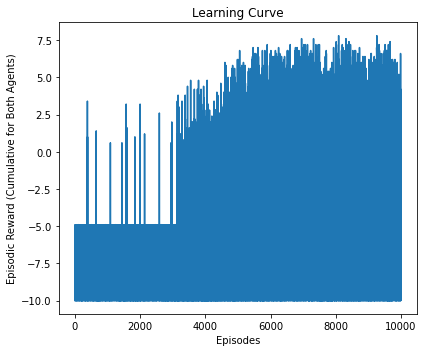

In [ ]:
DQN.DQN_Plot()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  This is separate from the ipykernel package so we can avoid doing imports until


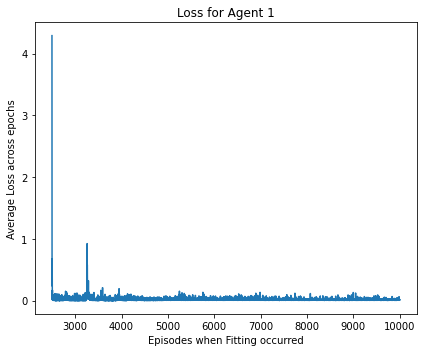

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  This is separate from the ipykernel package so we can avoid doing imports until


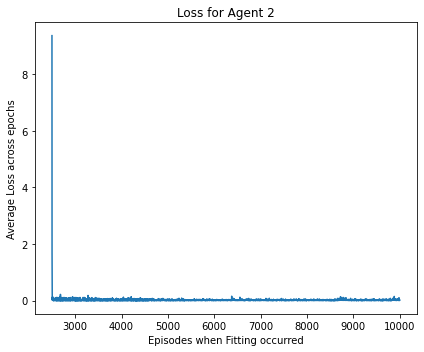

#### Analysis on performance

**Method:** I implemented a Deep Q Network (DQN) to solve this problem. The only input to these networks are the agents’ independent states, along with the timestep. I used an individual ANN for each network, which was routinely fitted by random sampling from an experience replay. This was done at regular intervals, instead of after each action, in an attempt to keep the data i.i.d. Before fitting begins, the agents are allowed to explore the environment randomly, in order to adequately fill the replay memory. This stops the agents taking the first plausible strategy and getting stop in a local minimum.
Effectiveness/Results: The results can be seen in the Learning Curve, the two Loss Graphs and the Testing Phase.

Testing: Even though it is not explicitly requested, the system was tested by just drawing actions from the networks (no exploration) and visualising the system. The system does not **always** work, due to randomness(and other defects described here), although it **often** works and the Learning Curve shows that it does learn adequately.

**Analysis:** The system works well – it achieves a solution which satisfies the reward criteria in an effective manner, taking advantage of the timestep information provided to the networks in a manner such that one agent waits for the other to complete the course before they start their action. The optimal minimum number of steps to complete is 13, and this system regularly gets close to this optimum. This is verified by the visual video, along with the graphs provided.

The Learning Curve is intriguing, my method of training plateaus the system at a relatively high epsilon, so that it can learn not to get stuck in local minima. This, along with the relative disparate of the system (due to the lack of a target network perhaps) means that the reward seems to oscillate between episodes, although the maximum reward increases, showing that learning is occurring. Target Networks, full grid-searching hyperparameter optimisation, target frequency optimisation and the like would remove this uncertainty/oscillation within the system. Even when the system fails, visualising the movement shows that the two agents are just out of time with one another and get stuck in the corridor, meaning that they have already learned their own strategies (they are not moving randomly) but have badly estimated the timestep aspect. This shows that each agent is learning well.

The loss function graphs offer good insight into the inner workings of the system. The small oscillation on the loss graph is as expected, since the policy is constantly changing. If the loss graphs were to show spikes, this could be indicative of exploding gradients, which can imply that the agent has hit a local optimum/results that are unexpected and hence the policy has changed dramatically (ie when the agent gets stuck in the corridor). Gradient Clipping can often remedy this. The lack of spikes in my loss graphs shows that they each conform to a global minimum and optimal policy well.

**Words: 493**

**Sources (Note only papers are fully cited, as BibTex referencing for websites is unavailable in notebooks):**

Mnih, V., Kavukcuoglu, K., Silver, D. et al. Human-level control through deep reinforcement learning. Nature 518, 529–533 (2015). https://doi.org/10.1038/nature14236

https://keras.io/callbacks/ (For Loss History Class)

https://medium.com/@jonathan_hui/rl-dqn-deep-q-network-e207751f7ae4

https://pythonprogramming.net/training-deep-q-learning-dqn-reinforcement-learning-python-tutorial/?completed=/deep-q-learning-dqn-reinforcement-learning-python-tutorial/

https://towardsdatascience.com/dqn-part-1-vanilla-deep-q-networks-6eb4a00febfb

https://www.analyticsvidhya.com/blog/2019/04/introduction-deep-q-learning-python/

